# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Exploration des données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


file_path = "marketing_campaign.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "imakash3011/customer-personality-analysis",
    file_path,
)

import io

csv_buffer = io.StringIO(df.to_csv(index=False))
df_corrected = pd.read_csv(csv_buffer, sep='\t')

print(df_corrected.head())

df_corrected.to_csv('../data/marketing_campaign.csv', index=False)
df = df_corrected

c:\Users\inesl\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\inesl\AppData\Local\Temp\ipykernel_14448\3561343639.py:16: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

## 1. Exploration des données

### The Head 

In [2]:
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### The Tail 

In [3]:
df.tail(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0
2239,9405,1954,PhD,Married,52869.0,1,1,15-10-2012,40,84,...,7,0,0,0,0,0,0,3,11,1


### Numerical Summary of Data

In [4]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


### Shape

In [5]:
print(f'Shape of the Data: {df.shape}')
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Shape of the Data: (2240, 29)
Rows: 2240
Columns: 29


### Info 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Categorical Columns

In [7]:
Cat_cols_train = [col for col in df.columns if df[col].dtype == 'O']
print(f'The Categorical Columns of Data are: {Cat_cols_train}')

The Categorical Columns of Data are: ['Education', 'Marital_Status', 'Dt_Customer']


### Numerical Columns

In [8]:
N_cols_train = [col for col in df.columns if df[col].dtype in ['float' ,'int']]
print(f'The Numerical Columns of Data are: {N_cols_train}')

The Numerical Columns of Data are: ['Income']


### Null Values

In [9]:
null_values = df.isnull().sum()
print(null_values)

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


### Duplicates Check

In [10]:
if df.duplicated().any():
    print('Duplicates exist in the dataset.')
    print(f'Number of duplicate rows: {df.duplicated().sum()}')
    print('Duplicate rows:')
    print(df[df.duplicated()])
else:
    print('No duplicates found in the dataset.')

No duplicates found in the dataset.


## 2. Clean data, Visualization

### Handling Missing value 
( Gestion des valeurs manquantes )

In [11]:
print("Before Impuation Null Values:", df['Income'].isnull().sum())
df['Income'].fillna(df['Income'].median(), inplace=True)
print("After Imputation Null Values:", df['Income'].isnull().sum())

# Or df = df.fillna(df.median(numeric_only=True)) for all numeric columns

Before Impuation Null Values: 24
After Imputation Null Values: 0


C:\Users\inesl\AppData\Local\Temp\ipykernel_14448\325914641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


### Convert Dt_Customer to DateTime
( Tranformer Dt_Customer en DateTime )

In [12]:
df["Dt_Customer"] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Dt_Customer'].dtypes

dtype('<M8[ns]')

### Distribution of Marital_Status 
( Distribution de Marital_Status )

In [13]:
value_counts_df = df['Marital_Status'].value_counts().reset_index()
value_counts_df.columns = [df['Marital_Status'].name, 'Count']
print(value_counts_df)


  Marital_Status  Count
0        Married    864
1       Together    580
2         Single    480
3       Divorced    232
4          Widow     77
5          Alone      3
6         Absurd      2
7           YOLO      2


### Extract age from birth year
( Extraire l'âge à partir de l'année de naissance )

In [14]:
reference_date = datetime(2014, 1, 1)
df['age'] = reference_date.year - df['Year_Birth']

### Total amount spend by customer in last 2 years
( Montant total dépensé par le client au cours des deux dernières années )

In [15]:
df['total_spent']=df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

### Total children in the home
( Nombre total d'enfants dans le foyer )

In [16]:
df['total_children']=df['Kidhome']+df['Teenhome']

### Drop useless data
( Enlever les attributs inutiles )

In [17]:
df_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(df_drop, axis=1)

## Visualization 
( Visualisation )

### Visualisation de la distribution des attributs

C:\Users\inesl\AppData\Local\Temp\ipykernel_14448\272266373.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


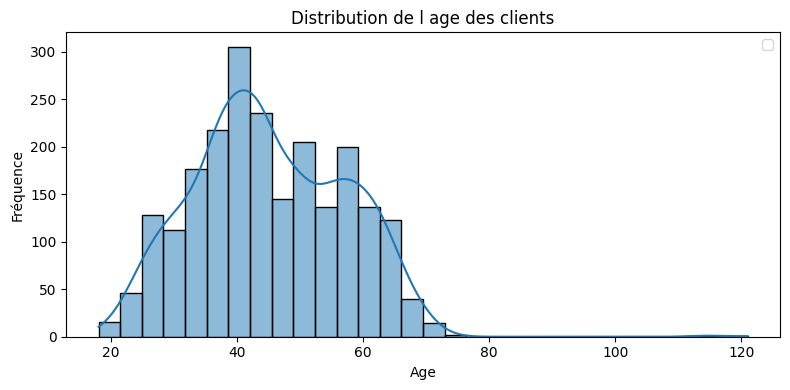

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution de l age des clients')
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.legend()
plt.tight_layout()

C:\Users\inesl\AppData\Local\Temp\ipykernel_14448\2822591014.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


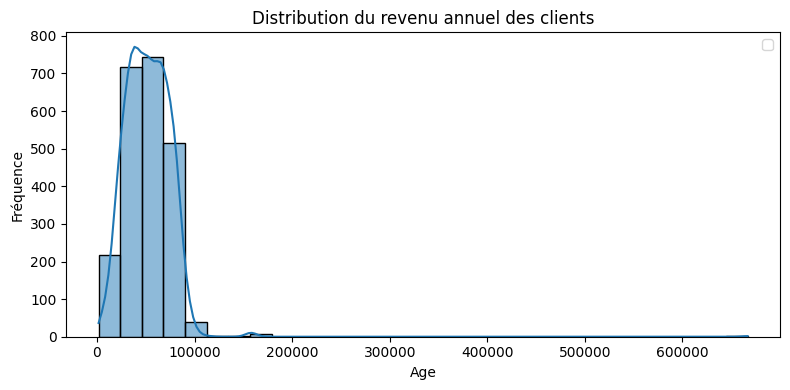

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Income'], bins=30, kde=True)
plt.title('Distribution du revenu annuel des clients')
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.legend()
plt.tight_layout()

### Remove outliers from age and income
( Enlever les données abérantes de l'age et du revenu annuel )

In [20]:
df = df[(df["age"]<80)]
df = df[(df["Income"]<1_50_000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2229


### Numerical Summary

In [21]:
df.describe()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,total_spent,total_children
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,...,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,51619.504262,0.444594,0.507402,49.106326,304.991476,26.348587,165.283984,37.642441,27.161507,44.113055,...,0.073127,0.074921,0.072678,0.064603,0.013459,0.008973,0.149843,45.111261,605.541050,0.951996
std,20601.216248,0.538636,0.544735,28.946476,336.761943,39.764060,219.336589,54.700548,41.338945,52.091255,...,0.260403,0.263324,0.259666,0.245879,0.115255,0.094319,0.356998,11.707430,601.032228,0.751976
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000
25%,35416.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,176.000000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,397.000000,1.000000
75%,68118.000000,1.000000,1.000000,74.000000,505.000000,33.000000,231.000000,50.000000,34.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,1044.000000,1.000000
max,113734.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,74.000000,2525.000000,3.000000


## 🔍 Exploratory Analysis – Data Summary (Analyse exploratoire – Résumé des données)

### 💰 Income
- **Average income**: 45.111 
  (*Revenu moyen : 45.111*)

### 🎂 Age
- **Average age**: ~56 years  
  (*Âge moyen : ~56 ans*)

### 👶 Children at Home
- **Average number of kids**: ~0.9  
  (*Nombre moyen d’enfants : ~0,9*)  
- **Total children (kidhome + teenhome)** ranges from 0 to 4  
  (*Nombre total d’enfants (Kidhome + Teenhome) varie de 0 à 4*)

### 💸 Total Spending
- **Range**: 0 to 2525  
  (*Plage de dépenses : de 0 à 2525*)  
- **Higher spenders** tend to:
  - **Purchase across more categories** (*Achètent dans plus de catégories*)
  - **Have more web/catalog purchases** (*Font plus d’achats en ligne et par catalogue*)

### 🍖 Spending Categories
- **Top spending areas**:
  - 1️⃣ Meat Products  
    (*Produits à base de viande*)
  - 2️⃣ Wines  
    (*Vins*)
- **Followed by**: Gold Products, Fish, Sweets  
  (*Suivis par : Produits en or, poisson, sucreries*)  
- **Fruits are less purchased**  
  (*Les fruits sont moins achetés*)

### 🛍️ Purchase Channels (Web, Store, Catalog)
- **Store purchases dominate** (avg ~5.8)  
  (*Les achats en magasin dominent – moyenne ~5,8*)  
- **Catalog** and **Web purchases** are also significant (2.7 and 4.1)  
  (*Les achats par catalogue et en ligne sont aussi significatifs – 2,7 et 4,1*)  

### 📢 Campaign Acceptance
- **Low acceptance rates** (e.g. 7% for Campaign 3)  
  (*Faibles taux d’acceptation – ex : 7 % pour la campagne 3*)  
- **Few customers accept all campaigns**  
  (*Peu de clients acceptent toutes les campagnes – cibles à forte valeur*)

### 📊 Total Campaigns Accepted
- **Most customers accepted 0–1 campaigns**  
  (*La plupart des clients ont accepté 0 à 1 campagne*)  
- **Rare cases accepted all 5** (e.g. high-income customer)  
  (*Cas rares : 5 campagnes acceptées – ex : client avec revenu élevé*)

### 😡 Complaints
- **Rare (~0.9%)**  
  (*Très rares – ~0,9 %*)  

### ✅ Response Rate
- **Low (~15%)**  
  (*Faible – ~15 %*)  
- Could reflect poor targeting or weak messaging  
  (*Peut indiquer un mauvais ciblage ou message inefficace*)

### 🌐 Web Visits
- **Average ~5.3/month**  
  (*Moyenne ~5,3 visites/mois*)  
- Some customers visit frequently → high engagement  
  (*Certains clients très engagés visitent plus souvent*)  

---

## 👑 High-Value Customer Traits (Caractéristiques des clients à forte valeur)

- **High total spending** (e.g. 2525)  
  (*Dépenses totales élevées – ex : 2525*)  
- **High income**  
  (*Revenu élevé*)  
- **Multiple children**  
  (*Plusieurs enfants*)  
- **Accepted all campaigns**  
  (*A accepté toutes les campagnes*)  
- **Spends across all categories**, including luxury (gold)  
  (*Achète dans toutes les catégories, y compris les produits de luxe comme l’or*)  
- **More likely to use web & catalog channels**  
  (*Achète plus souvent en ligne et par catalogue*)  
- **Key targets for loyalty and marketing**  
  (*Cibles clés pour la fidélisation et le marketing ciblé*)


### Correlation matrix
( Matrice de corrélation)

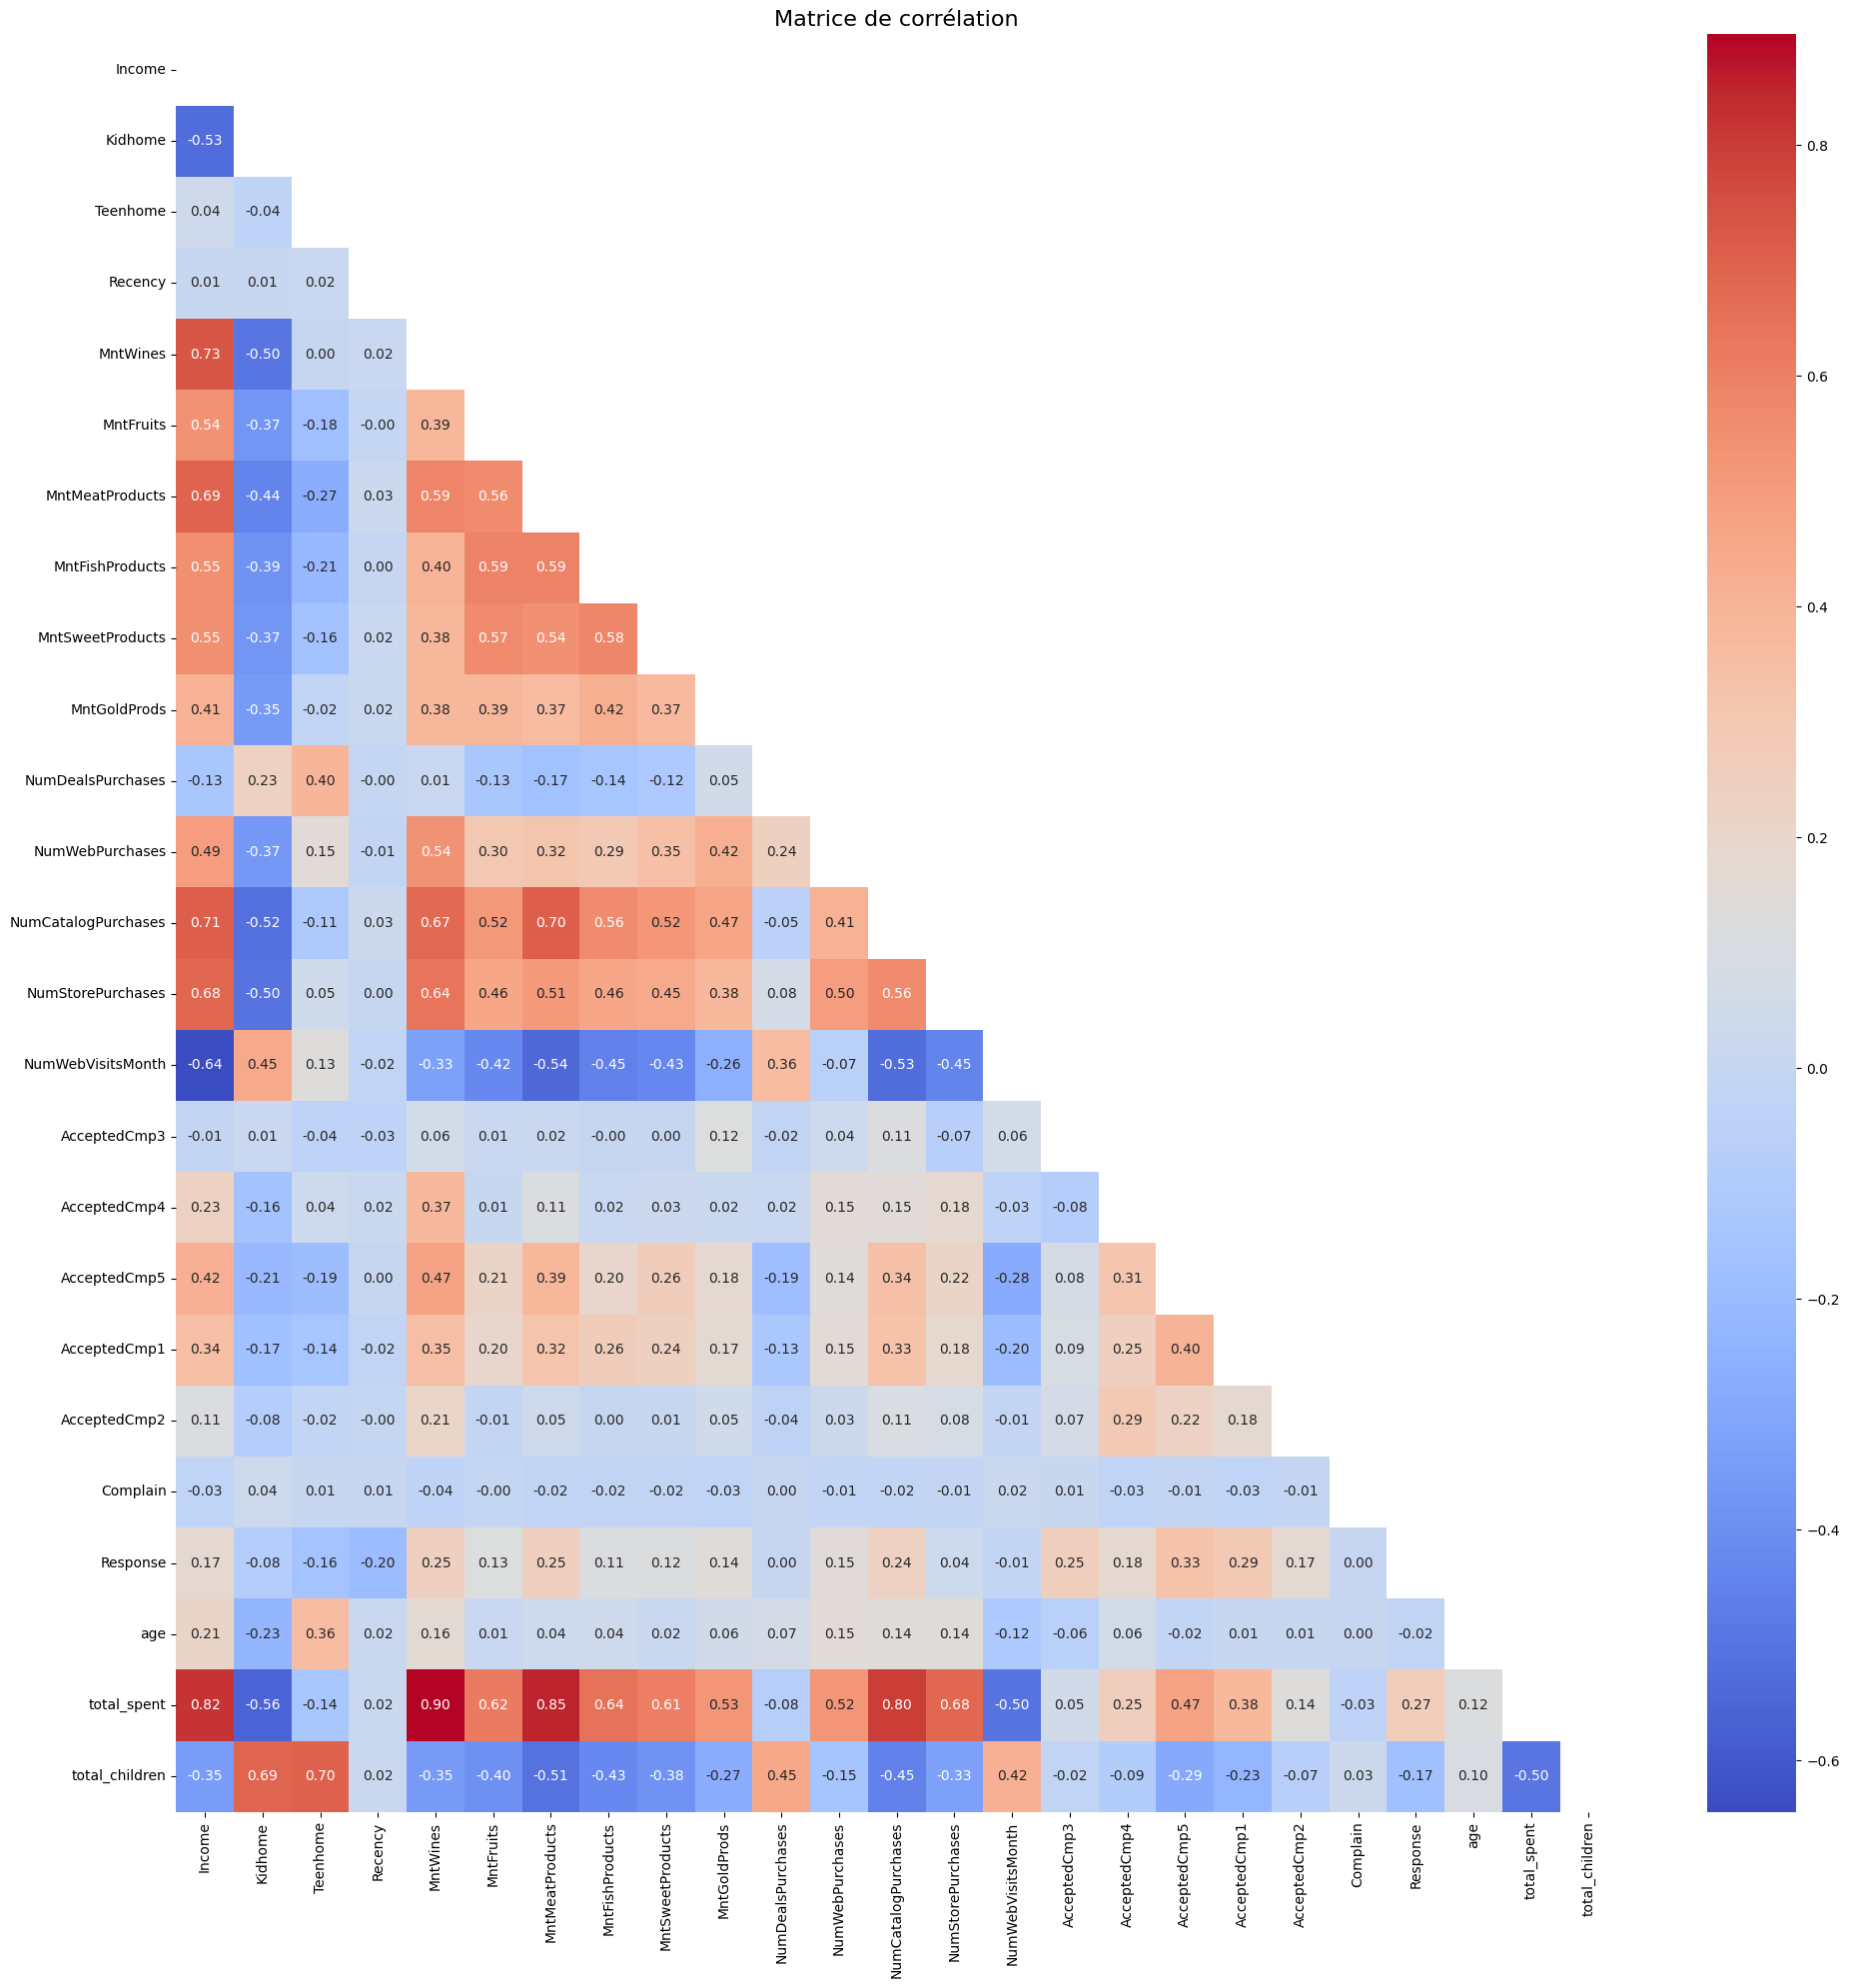

In [22]:
plt.figure(figsize=(20,20))

corr = df.select_dtypes('number').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f')

plt.title('Matrice de corrélation', fontsize=16)
plt.tight_layout()
plt.show()


**Visualiser les clusters potentiels**

**Explorer les relations**

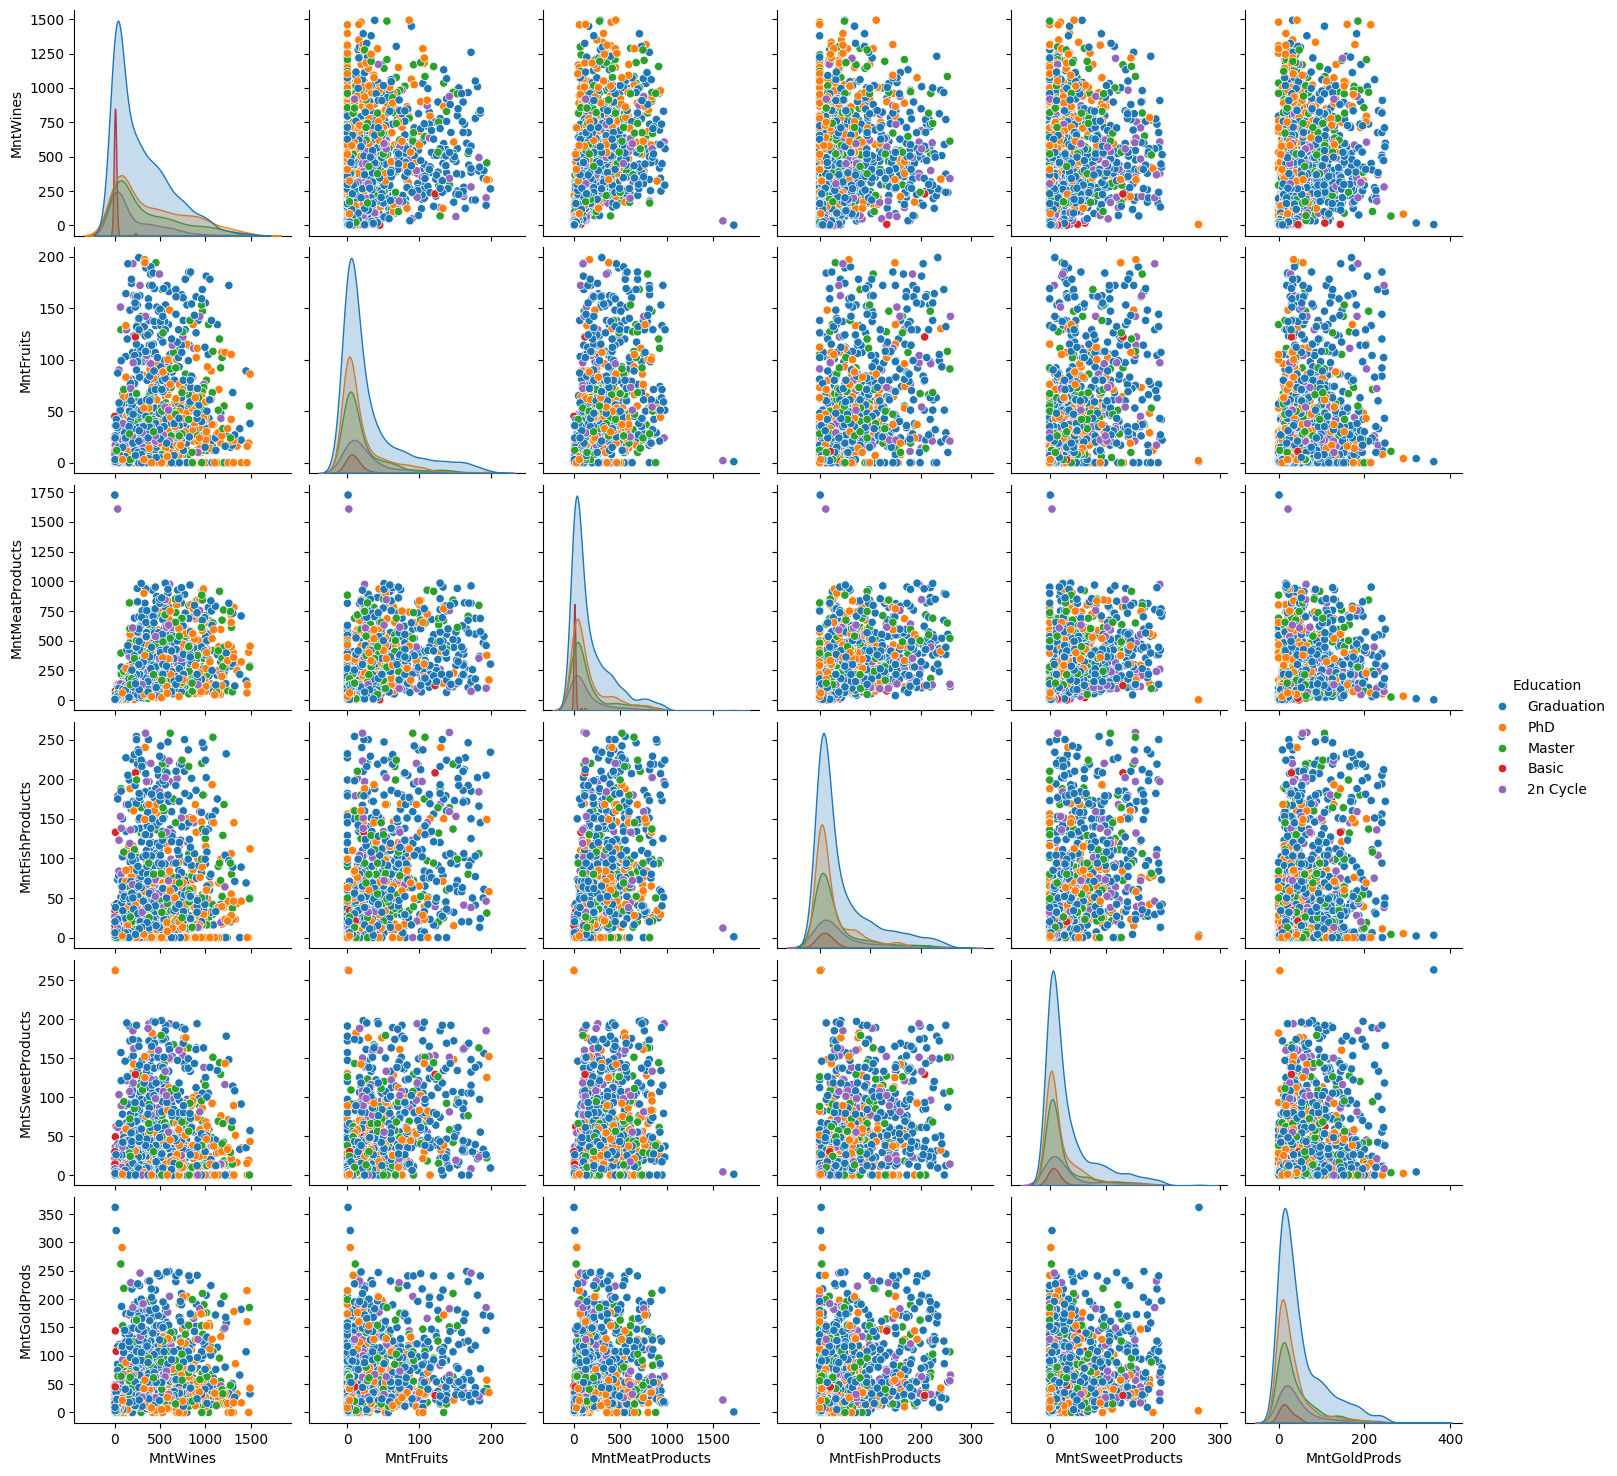

In [23]:
sns.pairplot(df, vars=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], hue="Education")

## 3. Réduction de dimension

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(scaled_data)
print('Nombre de composantes conservées :', pca.n_components_)

NameError: name 'scaled_data' is not defined

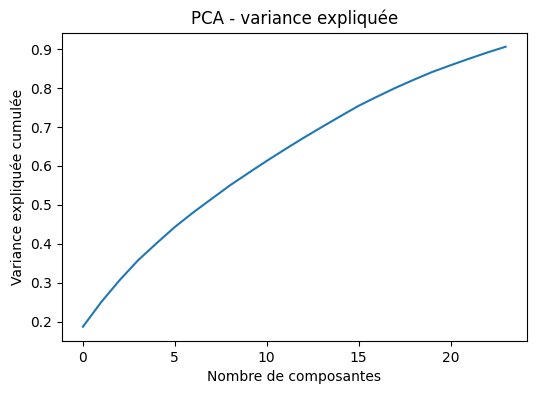

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

## 4. Méthodes de clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels_kmeans = kmeans.fit_predict(reduced_data)
sil_kmeans = silhouette_score(reduced_data, labels_kmeans)

cah = AgglomerativeClustering(n_clusters=4)
labels_cah = cah.fit_predict(reduced_data)
sil_cah = silhouette_score(reduced_data, labels_cah)

dbscan = DBSCAN(eps=2, min_samples=5)
labels_db = dbscan.fit_predict(reduced_data)
mask = labels_db != -1
sil_db = silhouette_score(reduced_data[mask], labels_db[mask]) if mask.sum() > 1 else np.nan

print('Silhouette K-means:', sil_kmeans)
print('Silhouette CAH:', sil_cah)
print('Silhouette DBSCAN:', sil_db)

Silhouette K-means: 0.09093945737700192
Silhouette CAH: 0.10508710083706967
Silhouette DBSCAN: 0.23321414181374656


### Visualisation des clusters (PCA 2D)

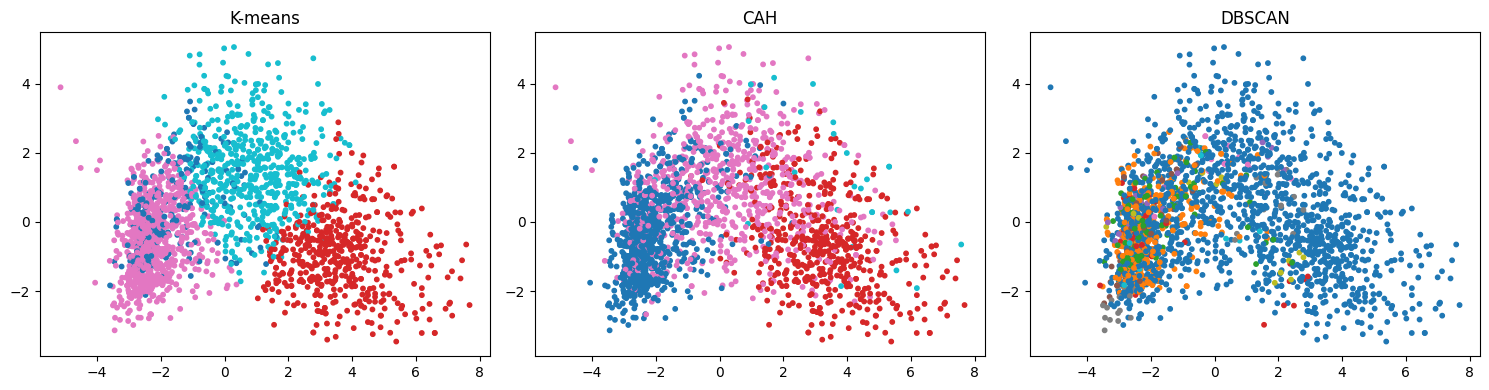

In [ ]:
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(scaled_data)

fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, labels, title in zip(axes, [labels_kmeans, labels_cah, labels_db], ['K-means', 'CAH', 'DBSCAN']):
    ax.scatter(reduced_2d[:,0], reduced_2d[:,1], c=labels, cmap='tab10', s=10)
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 5. Profiling des groupes

In [ ]:
df_clusters = df.copy()
df_clusters['Cluster_KMeans'] = labels_kmeans
profil_kmeans = df_clusters.groupby('Cluster_KMeans').mean(numeric_only=True)
profil_kmeans

ValueError: Length of values (2240) does not match length of index (2205)

## 6. Conclusion

Les différentes méthodes de clustering présentent des performances variables selon le score de silhouette.
Les groupes obtenus peuvent être étudiés au travers des moyennes des variables pour identifier des profils types de clients.